In [1]:
import os, sys
sys.path.append(os.path.abspath('../../src/'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from model.spectogram_dataset import SpectrogramDataset
from torch.utils.data import DataLoader
from utils.daps_explorer import DapsExplorer

DATASETS_PARENT_PATH = 'datasets'
DATASET_PATH = 'dataset'
DATA_DIR = os.path.join('../../', DATASETS_PARENT_PATH, DATASET_PATH)
BATCH_SIZE = 1

In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = SpectrogramDataset(
    data_dir=os.path.join(DATA_DIR, "test"),
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test loader created with batch size {BATCH_SIZE}")

Test dataset size: 1878
Test loader created with batch size 1


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, dropout_conv_p=0.0, dropout_fc_p=0.0, use_batchnorm=True):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(16) if use_batchnorm else None
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32) if use_batchnorm else None
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout_conv = nn.Dropout2d(p=dropout_conv_p)

        self.fc1 = nn.Linear(32 * 18 * 18, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)   
        
        self.dropout_fc = nn.Dropout(p=dropout_fc_p)

    def forward(self, x):
        x = self.conv1(x)
        if self.bn1:
            x = self.bn1(x)
        x = F.relu(x) 
        x = self.pool1(x)
        x = self.dropout_conv(x)

        x = self.conv2(x)
        if self.bn2:
            x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout_conv(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = torch.sigmoid(self.fc3(x))
        
        return x

In [4]:
def fgsm_attack_and_evaluate(model, device, data_loader, epsilon, num_examples_to_print=3):
    model.eval()
    total = 0
    correct_normal = 0
    correct_adversarial = 0
    perturbed_examples = []

    for batch_idx, (inputs, labels) in enumerate(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True

        outputs_normal = model(inputs)
        preds_normal = (outputs_normal > 0.5).float()
        correct_normal += (preds_normal.squeeze() == labels).sum().item()

        loss = F.binary_cross_entropy(outputs_normal, labels.unsqueeze(1).float())
        model.zero_grad()
        loss.backward()
        data_grad = inputs.grad.data

        perturbed_inputs = inputs + epsilon * data_grad.sign()
        perturbed_inputs = torch.clamp(perturbed_inputs, 0, 1)

        # Forward pass on adversarial inputs
        outputs_adversarial = model(perturbed_inputs)
        preds_adversarial = (outputs_adversarial > 0.5).float()
        correct_adversarial += (preds_adversarial.squeeze() == labels).sum().item()

        if batch_idx < num_examples_to_print:
            perturbed_examples.append(
                (inputs.cpu().detach(), 
                 perturbed_inputs.cpu().detach(), 
                 labels.cpu().detach(), 
                 preds_adversarial.cpu().detach())
            )

        total += labels.size(0)

    normal_accuracy = correct_normal / total
    adversarial_accuracy = correct_adversarial / total

    return normal_accuracy, adversarial_accuracy, perturbed_examples

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net()

model_path = "network-to-attack.pth"
model = torch.load(model_path, map_location=device)
model.to(device)
model.eval()

/tmp/ipykernel_14338/2948790489.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=23040, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout_fc): Dropout(p=0.4, inplace=False)
)

In [22]:
import numpy
epsilon_values = [0.005, 0.01, 0.015, 0.02]
accuracies = []

for epsilon in epsilon_values:
    normal_accuracy, adversarial_accuracy, examples = fgsm_attack_and_evaluate(
        model, device, test_loader, epsilon, num_examples_to_print=2
    )
    
    accuracies.append((epsilon, normal_accuracy, adversarial_accuracy))

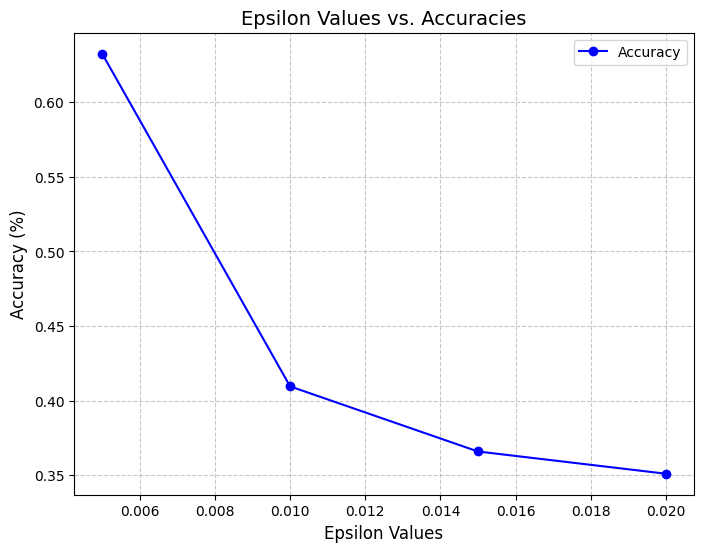

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, [adv for _, _, adv in accuracies], marker='o', linestyle='-', color='b', label='Accuracy')


plt.xlabel('Epsilon Values', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Epsilon Values vs. Accuracies', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.show()

--- Results for epsilon = 0.005 ---
Accuracy on normal images: 96.65%
Accuracy on adversarial images: 35.09%


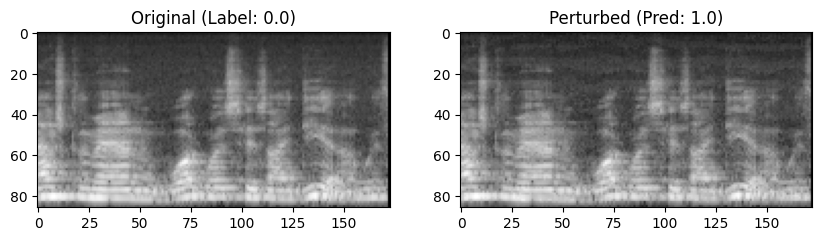

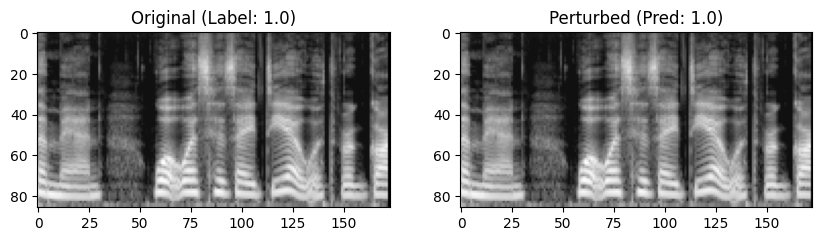

--- Results for epsilon = 0.01 ---
Accuracy on normal images: 96.65%
Accuracy on adversarial images: 35.09%


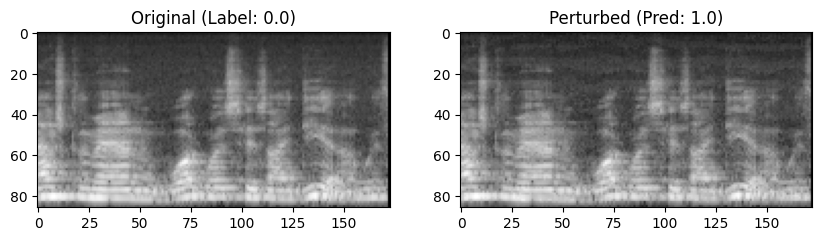

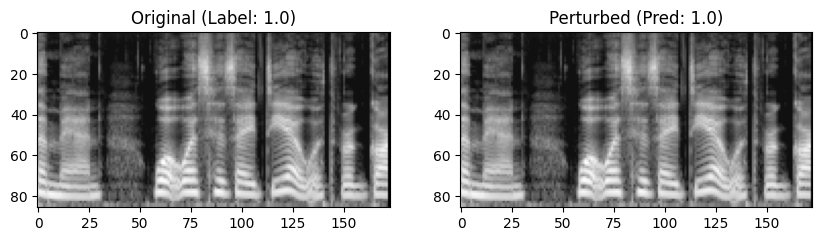

--- Results for epsilon = 0.015 ---
Accuracy on normal images: 96.65%
Accuracy on adversarial images: 35.09%


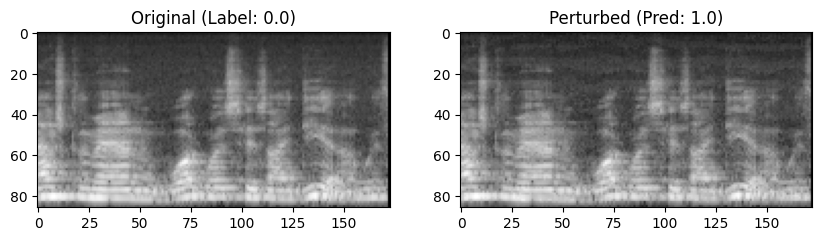

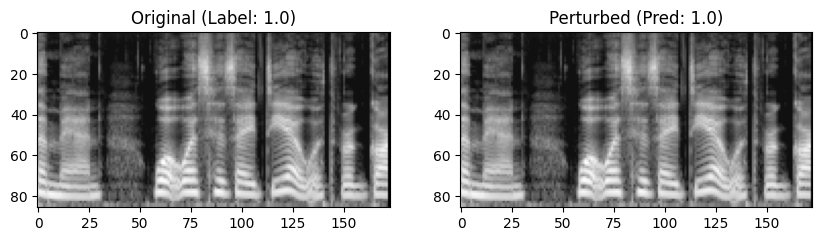

--- Results for epsilon = 0.02 ---
Accuracy on normal images: 96.65%
Accuracy on adversarial images: 35.09%


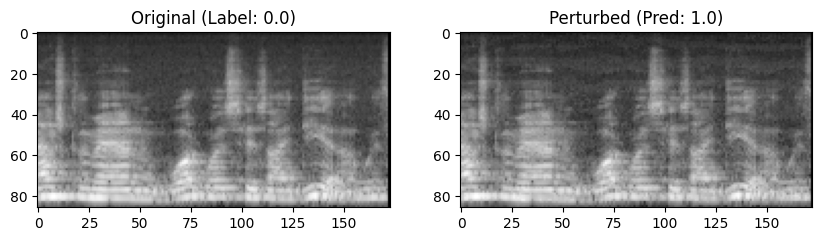

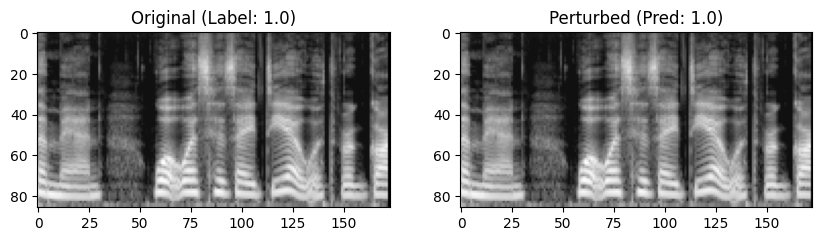


--- Accuracy Summary ---
Epsilon | Normal Accuracy (%) | Adversarial Accuracy (%)
   0.01 |               96.65 |                    63.26
   0.01 |               96.65 |                    40.95
   0.01 |               96.65 |                    36.58
   0.02 |               96.65 |                    35.09


In [24]:
if (not os.path.exists('wav_files')):
    os.mkdir('wav_files')

max_db = 40
min_db = -40
for epsilon in epsilon_values:
    print(f"--- Results for epsilon = {epsilon} ---")
    print(f"Accuracy on normal images: {normal_accuracy * 100:.2f}%")
    print(f"Accuracy on adversarial images: {adversarial_accuracy * 100:.2f}%")
    
    for i, (original, perturbed, label, pred) in enumerate(examples):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title(f"Original (Label: {label.item()})")
        plt.imshow(original.squeeze().numpy(), cmap="gray")
       
        DapsExplorer.save_wav_from_specgram(f'wav_files/original_{i}.wav',  original.squeeze() * (max_db - min_db) + min_db)

        plt.subplot(1, 2, 2)
        plt.title(f"Perturbed (Pred: {pred.item()})")
        plt.imshow(perturbed.squeeze().numpy(), cmap="gray")
        plt.show()
        DapsExplorer.save_wav_from_specgram(f'wav_files/pertubated_{i}_eps{epsilon}.wav',  perturbed.squeeze() * (max_db - min_db) + min_db)

print("\n--- Accuracy Summary ---")
print("Epsilon | Normal Accuracy (%) | Adversarial Accuracy (%)")
for epsilon, normal_acc, adv_acc in accuracies:
    print(f"{epsilon:7.2f} | {normal_acc * 100:19.2f} | {adv_acc * 100:24.2f}")
